In [2]:
from google.colab import files
uploaded = files.upload()

Saving cards.csv to cards (1).csv


In [3]:
import pandas as pd
df=pd.read_csv('cards.csv')
df.head()

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


In [4]:
df.shape

(8155, 5)

In [5]:
df.isnull().sum()

,0
class index,0
filepaths,0
labels,0
card type,0
data set,0


In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
from google.colab import files
files.upload()  # choose cards_dataset.zip

Saving cards_images.zip to cards_images (1).zip


In [8]:
import zipfile

with zipfile.ZipFile("cards_images.zip", "r") as zip_ref:
    zip_ref.extractall("/content/cards_dataset")

In [9]:
import os
base_path = "/content/cards_dataset"
df["filepaths"] = df["filepaths"].apply(lambda x: os.path.join(base_path, x))

In [10]:
df.head()

,class index,filepaths,labels,card type,data set
0,0,/content/cards_dataset/train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,/content/cards_dataset/train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,/content/cards_dataset/train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,/content/cards_dataset/train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,/content/cards_dataset/train/ace of clubs/005.jpg,ace of clubs,ace,train


In [11]:
train_df=df[df['data set']=='train']
test_df=df[df['data set']=='test']
valid_df=df[df['data set']=='valid']

In [12]:
print(train_df.shape,valid_df.shape,test_df.shape)

(7625, 5) (265, 5) (265, 5)


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=64,
    shuffle=True
)

valid_gen = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=64,
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=64,
    shuffle=False
)

Found 7624 validated image filenames belonging to 53 classes.
Found 265 validated image filenames belonging to 53 classes.
Found 265 validated image filenames belonging to 53 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

unique_class=train_df['labels'].nunique()

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),   # reduce dropout
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(unique_class, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 53)             │         6,837 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,865,589 (37.63 MB)

 Trainable params: 9,865,589 (37.63 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 134s 994ms/step - accuracy: 0.0229 - loss: 4.0171 - val_accuracy: 0.0189 - val_loss: 3.9705
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 92s 763ms/step - accuracy: 0.0235 - loss: 3.9646 - val_accuracy: 0.0604 - val_loss: 3.6981
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 93s 771ms/step - accuracy: 0.0452 - loss: 3.6869 - val_accuracy: 0.1170 - val_loss: 3.0233
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 91s 757ms/step - accuracy: 0.1060 - loss: 3.1708 - val_accuracy: 0.1509 - val_loss: 2.7205
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 92s 763ms/step - accuracy: 0.1472 - loss: 2.9404 - val_accuracy: 0.2453 - val_loss: 2.5115
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 91s 759ms/step - accuracy: 0.1842 - loss: 2.7611 - val_accuracy: 0.3245 - val_loss: 2.1287
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 92s 765ms/step - accuracy: 0.2163 - loss: 2.5799 - val_accuracy: 0.3736 - val_loss: 1.9390
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 91s 757ms/step - accuracy: 0.2433 - loss: 

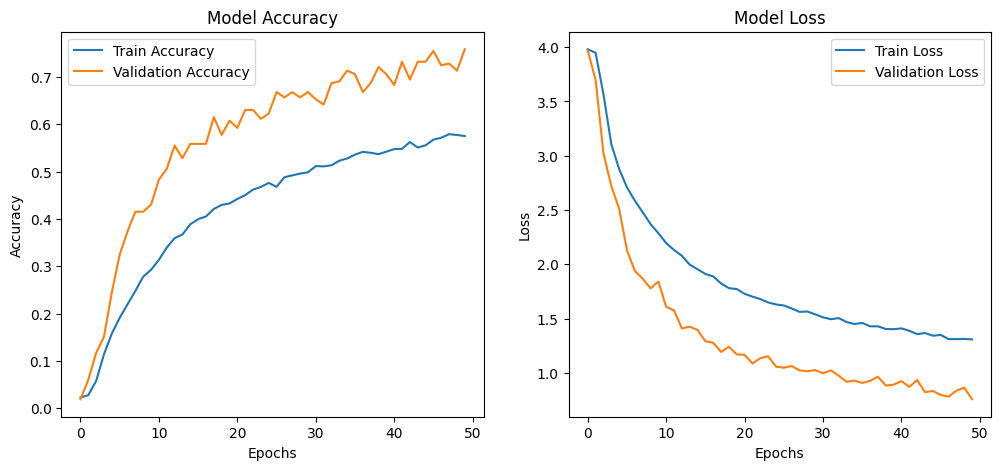

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
loss, acc = model.evaluate(valid_gen)
print(f"Test Accuracy: {acc*100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7819 - loss: 0.6818 
Test Accuracy: 75.85%


In [18]:
model.save("cards_classifier.h5")
print("Model saved as cards_classifier.h5")

Model saved as cards_classifier.h5


In [19]:
from google.colab import files
files.download("cards_classifier.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import json

class_labels = {v: k for k, v in train_gen.class_indices.items()}

with open("class_labels.json", "w") as f:
    json.dump(class_labels, f)

from google.colab import files
files.download("class_labels.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>